In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy, Accuracy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from models import *
from tqdm import tqdm
import build_tf_dataset
import load_dataset


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])


In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
df = load_dataset.give_dataframe()

In [4]:
ds = build_tf_dataset.give_classification_dataset(df)

In [5]:
for x, y in ds.take(1):
    im = x.numpy()[:,:,0]
    label = y.numpy()

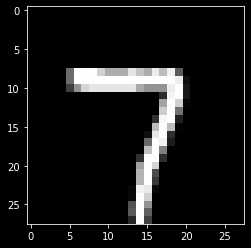

In [6]:
plt.imshow(im, cmap='binary')

In [7]:
contrastive_cnn = tf.keras.models.load_model(
    "../models/contrastive_model", custom_objects={"ContrastiveCNN": ContrastiveCNN}
)

In [8]:
inputs = tf.random.normal((1,28,28,1))
_ = contrastive_cnn(inputs)

In [10]:
contrastive_cnn.trainable = False

In [12]:
embeddings = np.zeros((df.shape[0],64))
labels = np.zeros((df.shape[0]))

In [18]:
for i, (image, label) in enumerate(ds.batch(1)):
    embedding = contrastive_cnn(image).numpy()
    embeddings[i, :] = embedding
    labels[i] = label.numpy()[0]

In [21]:
emb_df = pd.DataFrame(embeddings)

In [23]:
emb_df['label'] = labels.astype(int)

In [25]:
del embeddings
del labels

In [27]:
from sklearn.decomposition import PCA

In [47]:
pca_trans = PCA(n_components=2)
emb_reduced = pca_trans.fit_transform(emb_df.iloc[:,:-1])

In [79]:
sample = emb_reduced[:, :]
sample_y = emb_df.label[:].map(lambda x:str(x)).values

In [80]:
import seaborn as sns

In [81]:
mean_vecs = emb_df.groupby(by='label').median()

In [82]:
mean_vecs_trans = pca_trans.transform(mean_vecs)

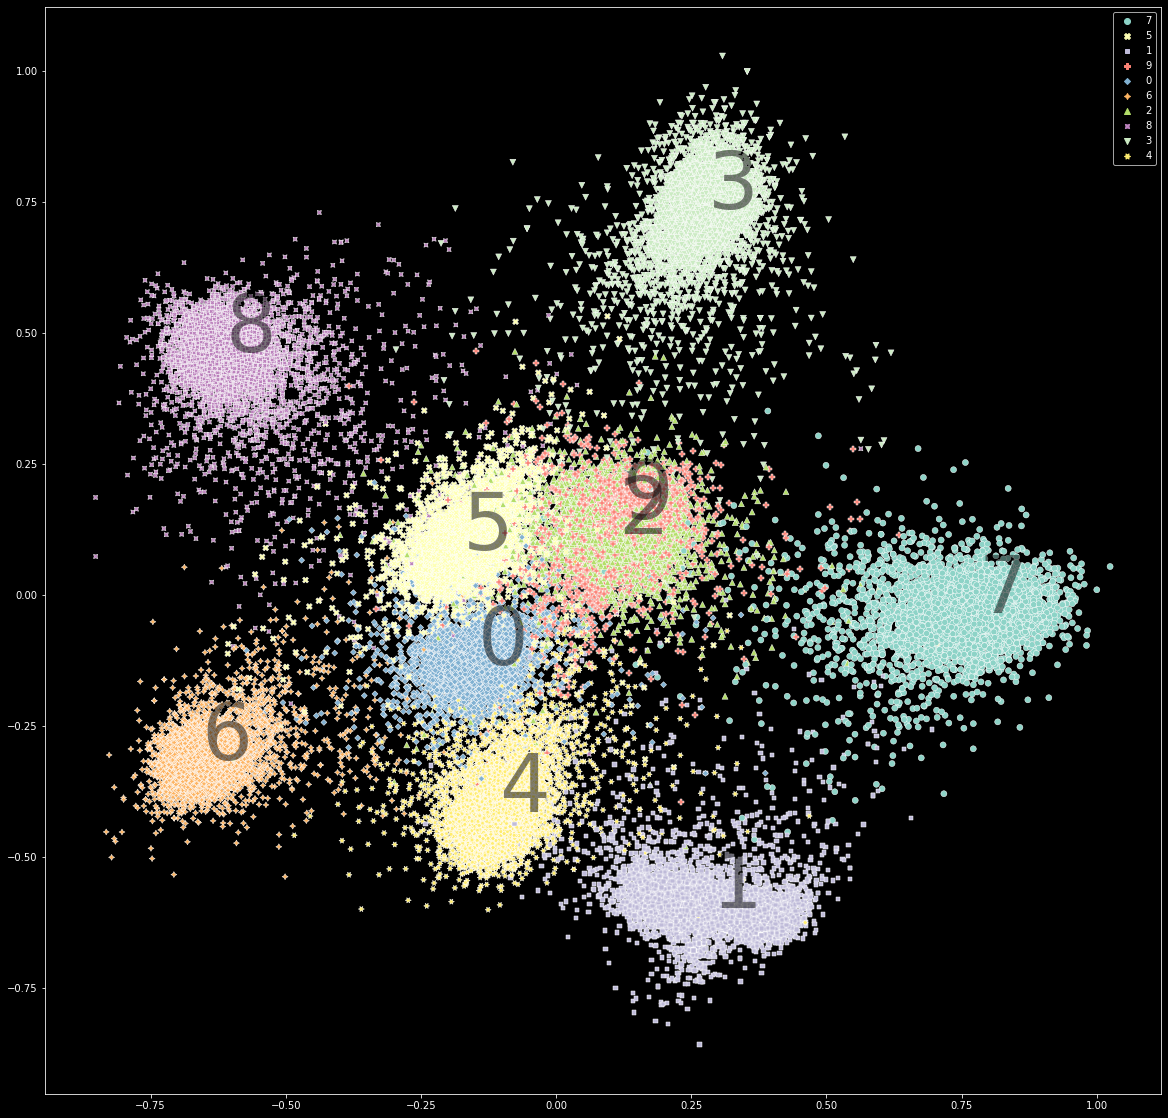

In [84]:
plt.figure(figsize=(20,20))
sns.scatterplot(x=sample[:,0], y=sample[:,1], hue=sample_y, style=sample_y, sizes=(1000,1000))
for i, row in enumerate(mean_vecs_trans):
    plt.text(*row, str(i),size=80, color='black', alpha=0.5)

In [96]:
optimizer = tf.keras.optimizers.Adam()

In [97]:
def give_image(number):
    image = tf.Variable(tf.random.uniform(shape=(1,28,28,1)))
    target_embedding = tf.constant(mean_vecs.loc[number].values.astype(np.float32))
    
    def forward(image):
        x = tf.multiply(image, 255)
        x = tf.squeeze(contrastive_cnn(x))
        return tf.math.reduce_mean(tf.math.square(x-target_embedding))
    
    for n in tqdm(range(10000)):
        with tf.GradientTape() as tape:
            loss = forward(image)
        grad = tape.gradient(loss, image) 
        #print(grad)
    #     print(grad.shape)
    #     print(image.shape)
        optimizer.apply_gradients([(grad, image)])

    return image.numpy()[0,:,:,0]

In [98]:
created_images = {}
for n in range(10):
    created_images[n] = give_image(n)

100%|██████████| 10000/10000 [00:55<00:00, 179.31it/s]


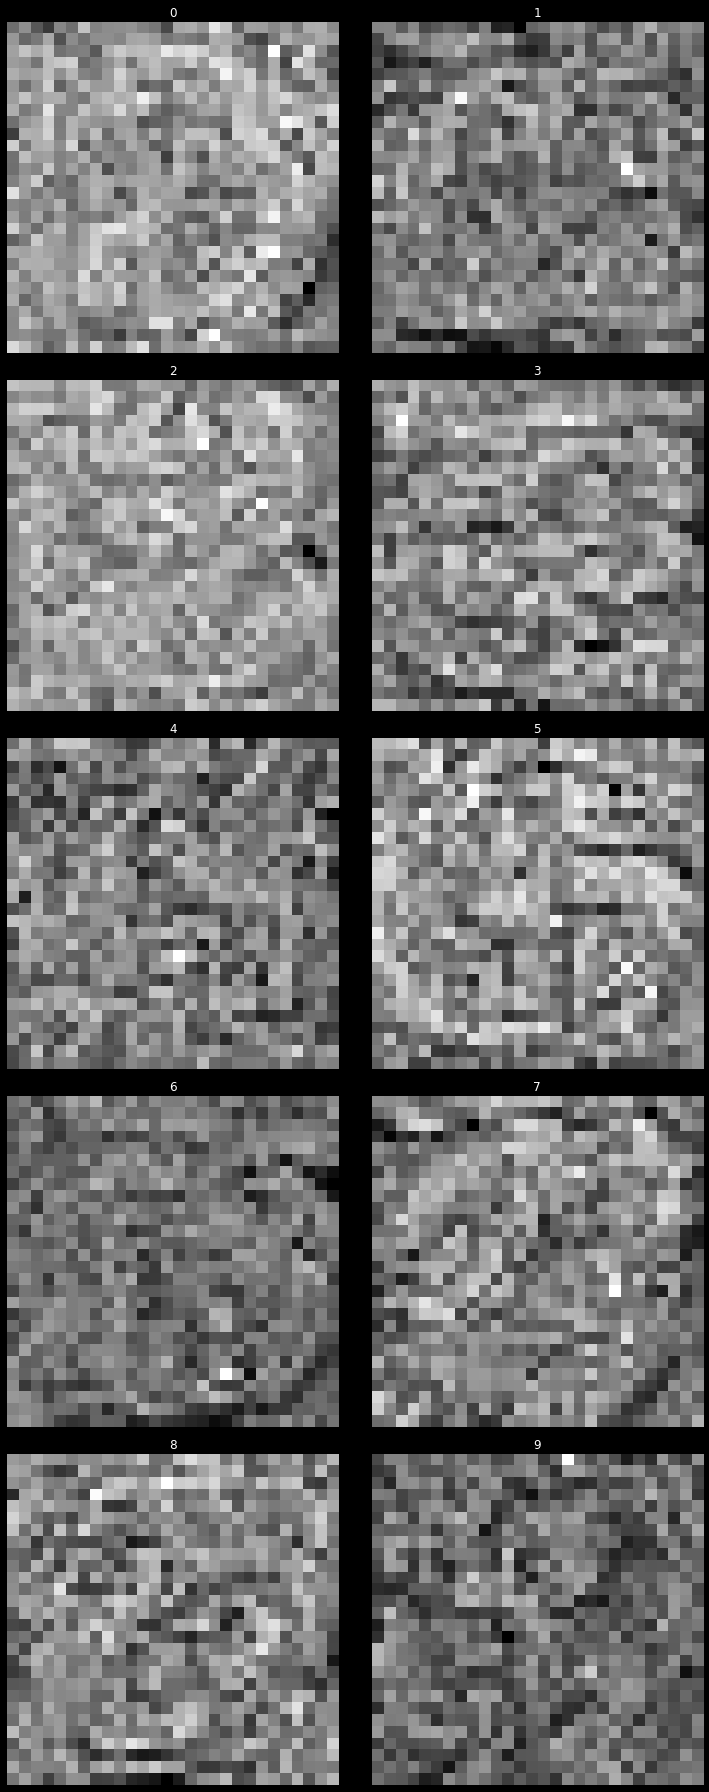

In [99]:
fig, axes = plt.subplots(5,2,figsize=(10,25))
for n in range(10):
    axis = axes.flatten()[n]
    img = created_images[n]
    
    axis.imshow(img, cmap='binary')
    axis.set_title(n)
    axis.axis('off')
    
plt.tight_layout(w_pad=5)